In [325]:
# 일단 RandomForest부터
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (f1_score, accuracy_score, roc_auc_score,
                             confusion_matrix, make_scorer, precision_score, recall_score)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearnex import patch_sklearn
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

In [326]:
patch_sklearn()  # Intel 및 GPU 최적화 활성화

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [327]:
import cupy as cp

# GPU 0번 선택
cp.cuda.Device(0).use()  # 0번 GPU 사용

<CUDA Device 0>

In [ ]:
## 파일 불러오기
fin_data = pd.read_csv("inyoung0202.csv")
fin_data

,airline,month,arrival_kor,delayed,WD,WS,WC,CA,TA,TD,...,pressure_diff,VS_category,TD_spread,fog_possibility,HM_category,rainy,rainy_windy,rainy_low_visibility,distance_category,CH_category_1
0,에미레이트항공,1,두바이,0,60.0,5.0,10.0,0.0,-0.7,-1.6,...,0.9,4,0.9,1,3,0,0,0,3,0
1,몽골항공,1,칭기즈 칸,0,60.0,5.0,10.0,0.0,-0.7,-1.6,...,0.9,4,0.9,1,3,0,0,0,2,0
2,카타르항공,1,도하,1,60.0,5.0,10.0,0.0,-0.7,-1.6,...,0.9,4,0.9,1,3,0,0,0,3,0
3,터키항공,1,이스탄불,0,60.0,5.0,10.0,0.0,-0.7,-1.6,...,0.9,4,0.9,1,3,0,0,0,4,0
4,젯스타 에어웨이즈,1,시드니,1,60.0,5.0,10.0,0.0,-0.7,-1.6,...,0.9,4,0.9,1,3,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179177,대한항공,12,싱가포르,0,60.0,3.0,0.0,0.0,-1.0,-6.0,...,0.9,5,5.0,0,1,0,0,0,3,0
179178,싱가폴항공,12,싱가포르,1,60.0,3.0,0.0,0.0,-1.0,-6.0,...,0.9,5,5.0,0,1,0,0,0,3,0
179179,청도항공,12,청도,0,60.0,3.0,0.0,0.0,-1.0,-6.0,...,0.9,5,5.0,0,1,0,0,0,1,0
179180,필리핀에어아시아,12,마닐라,0,60.0,3.0,0.0,0.0,-1.0,-6.0,...,0.9,5,5.0,0,1,0,0,0,2,0


In [329]:
fin_data['delayed'].value_counts()

delayed
0    91727
1    87455
Name: count, dtype: int64

In [330]:
fin_data.columns

Index(['airline', 'month', 'arrival_kor', 'delayed', 'WD', 'WS', 'WC', 'CA',
       'TA', 'TD', 'HM', 'RN', 'Hours', 'time_of_day',
       'avg_delay_rate_time_of_day', 'season', 'airline_delay_rate',
       'is_holiday', 'low_PA', 'pressure_diff', 'VS_category', 'TD_spread',
       'fog_possibility', 'HM_category', 'rainy', 'rainy_windy',
       'rainy_low_visibility', 'distance_category', 'CH_category_1'],
      dtype='object')

In [331]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179182 entries, 0 to 179181
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   airline                     179182 non-null  object 
 1   month                       179182 non-null  int64  
 2   arrival_kor                 179182 non-null  object 
 3   delayed                     179182 non-null  int64  
 4   WD                          179182 non-null  float64
 5   WS                          179182 non-null  float64
 6   WC                          179182 non-null  float64
 7   CA                          179182 non-null  float64
 8   TA                          179182 non-null  float64
 9   TD                          179182 non-null  float64
 10  HM                          179182 non-null  float64
 11  RN                          179182 non-null  float64
 12  Hours                       179182 non-null  int64  
 13  time_of_day   

In [332]:
# # Hours는 그냥 시간대로 변경
# fin_data['Hours'] = fin_data['Hours'].str.split(':').str[0].astype(int)

In [333]:
# fin_data = fin_data.drop(["month", 'day'], axis = 1)
# fin_data

In [334]:
# 레이블 인코딩에 대한 것은 함수로 만들어보자!
def encode_features(fin_data):
    features = ['airline', 'arrival_kor', 'time_of_day', 'season']          ## LabelEncoder를 적용할 변수
    for feature in features:
        le = LabelEncoder()
        le = le.fit(fin_data[feature])
        fin_data[feature] = le.transform(fin_data[feature])
    return fin_data

fin_data = encode_features(fin_data)

In [335]:
outliers_del = fin_data.drop("delayed", axis=1)

In [336]:
# 이상치 제거 함수화(모든 열에 적용하는 방식)
def remove_outliers(df):
    for column in outliers_del:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [337]:
## 이상치 제거
fin_data = remove_outliers(fin_data)

In [338]:
print(fin_data["delayed"].value_counts())

delayed
0    59241
1    57813
Name: count, dtype: int64


In [339]:
fin_data.isnull().sum()

airline                       0
month                         0
arrival_kor                   0
delayed                       0
WD                            0
WS                            0
WC                            0
CA                            0
TA                            0
TD                            0
HM                            0
RN                            0
Hours                         0
time_of_day                   0
avg_delay_rate_time_of_day    0
season                        0
airline_delay_rate            0
is_holiday                    0
low_PA                        0
pressure_diff                 0
VS_category                   0
TD_spread                     0
fog_possibility               0
HM_category                   0
rainy                         0
rainy_windy                   0
rainy_low_visibility          0
distance_category             0
CH_category_1                 0
dtype: int64

In [340]:
# 제외하기로 한 columns 제거
delete_columns = ["TD", "HM", "fog_possibility", "RN", "rainy_windy", "low_PA", "rainy_low_visibility"]
fin_data.drop(delete_columns, axis = 1).reset_index(drop=True)

,airline,month,arrival_kor,delayed,WD,WS,WC,CA,TA,Hours,...,season,airline_delay_rate,is_holiday,pressure_diff,VS_category,TD_spread,HM_category,rainy,distance_category,CH_category_1
0,76,1,7,0,330.0,3.0,0.0,6.0,3.2,10,...,3,0.520398,0,0.9,5,4.3,2,0,2,3
1,3,1,20,1,330.0,3.0,0.0,6.0,3.2,10,...,3,0.545834,0,0.9,5,4.3,2,0,4,3
2,3,1,77,0,330.0,3.0,0.0,6.0,3.2,10,...,3,0.545834,0,0.9,5,4.3,2,0,1,3
3,3,1,21,0,330.0,3.0,0.0,6.0,3.2,10,...,3,0.545834,0,0.9,5,4.3,2,0,1,3
4,54,1,7,0,330.0,3.0,0.0,6.0,3.2,10,...,3,0.485572,0,0.9,5,4.3,2,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117049,1,12,104,1,60.0,3.0,0.0,0.0,-1.0,23,...,3,0.269896,0,0.9,5,5.0,1,0,4,0
117050,3,12,95,0,60.0,3.0,0.0,0.0,-1.0,23,...,3,0.545834,0,0.9,5,5.0,1,0,3,0
117051,29,12,95,1,60.0,3.0,0.0,0.0,-1.0,23,...,3,0.407177,0,0.9,5,5.0,1,0,3,0
117052,81,12,46,0,60.0,3.0,0.0,0.0,-1.0,23,...,3,0.406807,0,0.9,5,5.0,1,0,2,0


In [341]:
# 일단은 전체 놓고 돌려보기 위해서 변수 지정
x = fin_data.drop("delayed", axis = 1)
y = fin_data["delayed"]

# 데이터에 대한 정규화(StandScaler 사용)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# smote = SMOTE(random_state = 42)        ## 가장 유명한 숫자 42!

# 학습 데이터와 테스트 데이터를 분리
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)
# x_train = x_train.astype('int')
# y_train = y_train.astype('int')

# x_oversampled, y_oversampled = smote.fit_resample(x_train, y_train)

# x_oversampled = cp.array(x_oversampled)
# y_oversampled = cp.array(y_oversampled)
### cuml을 쓰면서 더 이상 필요없어짐

In [342]:
## 커스텀 스코어링 함수 생성
def custom_scoring(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

In [343]:
### 함수 적용
custom_scorer = make_scorer(custom_scoring, greater_is_better=True)

In [346]:
# 랜덤포레스트 본격 적용
rf = RandomForestClassifier(random_state=42)

rf_param = {'n_estimators': [200], 'max_depth': [50], 'min_samples_split': [10], 'min_samples_leaf': [9], 'max_features': ['sqrt']}

rf_search = GridSearchCV(
    estimator = rf,
    param_grid = rf_param,
    scoring = custom_scorer,
    cv = StratifiedKFold(n_splits=5),
    verbose = 1
)

In [347]:
rf_search.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  war

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [50], 'max_features': ['sqrt'],
                         'min_samples_leaf': [9], 'min_samples_split': [10],
                         'n_estimators': [200]},
             scoring=make_scorer(custom_scoring, response_method='predict'),
             verbose=1)

In [312]:
# # 그냥 돌리면 320개의 오류가 나타난다는 것을 확인
# ## 검색 결과 해당 내용은 int가 아닌 타입이 있는 것으로 보임
# ### 따라서 확인
# x_train.info()

# ### x_train이 전부 float의 형태인 것으로 보임 -> 수정 후 전체 int64의 형태로 변경

In [313]:
# ### roc_auc 적용 시 오류 문제
# #### '-1'이 존재하는 것으로 보임 -> 확인 필요
# y_train.unique()

# # 해당 내용은 아닌 것으로 보이고.... 그렇다면 -1이 아닌 애들이 나오도록 조치 필요

# for column in x_train.columns:
#     if (x_train[column] == -1).any():
#         print(f"열 '{column}'에 -1이 포함되어 있습니다.")

In [348]:
# 최적 파라미터와 점수 출력
# print("Best PM : ", rf_search.best_params_)
print("Best roc-auc Score : ", rf_search.best_score_)

Best roc-auc Score :  0.7267474419454808


In [349]:
# 테스트 데이터 평가
y_pred_proba = rf_search.best_estimator_.predict_proba(x_test)[:, 1]
y_pred = (y_pred_proba >= 0.3).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

Test Accuracy: 0.6638332407842468
Test F1 Score: 0.7252670529916917
Test ROC-AUC: 0.8124977939584581


/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

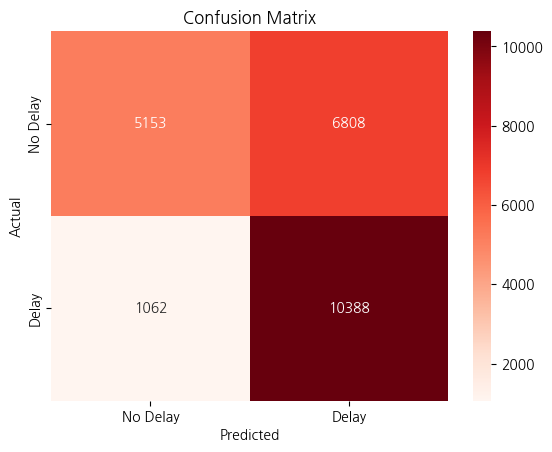

In [350]:
# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- 성능은 좋게 나왔으나, 불균형 데이터의 특성 때문인지, delayed로 예측하는 경우가 다수임
- 해당 건을 해결해보고자 하였으나, 가중치를 준다고 해결되지는 않는 상황...

In [351]:
y.value_counts()

### 애당초 불균형하다는 것은 이미 밝혔지만, 한번 더 굳이 확인을 하자면 이런 식이다.

delayed
0    59241
1    57813
Name: count, dtype: int64

In [352]:
# 임계값 조정 및 ROC-AUC 재평가
thresholds = np.arange(0.1, 1.0, 0.1)
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Threshold: {thresh:.1f}, F1 Score: {f1_score(y_test, y_pred_thresh):.4f}, ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

TN: 803, FP: 11158, FN: 76, TP: 11374
Threshold: 0.1, F1 Score: 0.6694, ROC-AUC: 0.8125
TN: 2890, FP: 9071, FN: 404, TP: 11046
Threshold: 0.2, F1 Score: 0.6998, ROC-AUC: 0.8125
TN: 5153, FP: 6808, FN: 1062, TP: 10388
Threshold: 0.3, F1 Score: 0.7253, ROC-AUC: 0.8125
TN: 7236, FP: 4725, FN: 1974, TP: 9476
Threshold: 0.4, F1 Score: 0.7388, ROC-AUC: 0.8125
TN: 9064, FP: 2897, FN: 3257, TP: 8193
Threshold: 0.5, F1 Score: 0.7270, ROC-AUC: 0.8125
TN: 10390, FP: 1571, FN: 4765, TP: 6685
Threshold: 0.6, F1 Score: 0.6785, ROC-AUC: 0.8125
TN: 11225, FP: 736, FN: 6439, TP: 5011
Threshold: 0.7, F1 Score: 0.5828, ROC-AUC: 0.8125
TN: 11688, FP: 273, FN: 8418, TP: 3032
Threshold: 0.8, F1 Score: 0.4110, ROC-AUC: 0.8125
TN: 11910, FP: 51, FN: 10300, TP: 1150
Threshold: 0.9, F1 Score: 0.1818, ROC-AUC: 0.8125


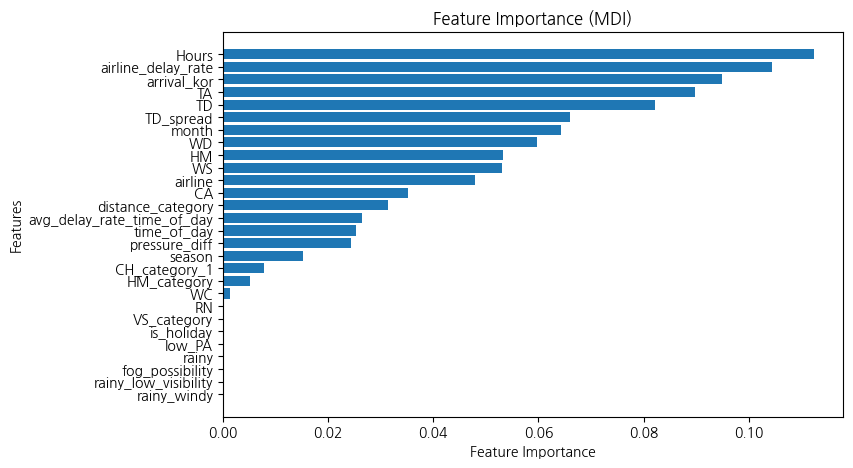

In [353]:
x_oversampled_df = pd.DataFrame(x_train, columns=x.columns)

best_rf_model = rf_search.best_estimator_

# Feature Importance 계산
feature_importance = best_rf_model.feature_importances_

# 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': x_oversampled_df.columns,  # x_oversampled의 컬럼 이름 사용
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# 중요도 시각화
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (MDI)')
plt.gca().invert_yaxis()
plt.show()

In [354]:
low_importance_features = importance_df[importance_df['Importance'] < 0.01]['Feature'].tolist()
print("제외할 특성:", low_importance_features)

제외할 특성: ['CH_category_1', 'HM_category', 'WC', 'RN', 'VS_category', 'is_holiday', 'low_PA', 'rainy', 'fog_possibility', 'rainy_low_visibility', 'rainy_windy']


In [355]:
x_filtered = x.drop(columns=low_importance_features)

In [356]:
scaler = StandardScaler()
x_filtered_scaled = scaler.fit_transform(x_filtered)
x_train, x_test, y_train, y_test = train_test_split(x_filtered_scaled, y, test_size=0.2, random_state=42, stratify=y)

# smote = SMOTE(random_state=42)
# x_oversampled, y_oversampled = smote.fit_resample(x_train, y_train)

# 모델 재학습
rf_search.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  war

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [50], 'max_features': ['sqrt'],
                         'min_samples_leaf': [9], 'min_samples_split': [10],
                         'n_estimators': [200]},
             scoring=make_scorer(custom_scoring, response_method='predict'),
             verbose=1)

In [357]:
# 최적 파라미터와 점수 출력
print("Best PM : ", rf_search.best_params_)
print("Best roc-auc Score : ", rf_search.best_score_)

Best PM :  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 200}
Best roc-auc Score :  0.728015672348163


In [358]:
# 테스트 데이터 평가
y_pred_proba = rf_search.best_estimator_.predict_proba(x_test)[:, 1]
y_pred = (y_pred_proba >= 0.4).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("Test Recall :", recall_score(y_test, y_pred))

Test Accuracy: 0.7152193413352698
Test F1 Score: 0.741839303000968
Test ROC-AUC: 0.8094797462779572
Test Recall : 0.8284182305630027


/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanted-1/miniconda3/envs/team4_work/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

In [359]:
# 임계값 조정 및 ROC-AUC 재평가
thresholds = np.arange(0.1, 1.0, 0.1)
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    print(f"Threshold: {thresh:.1f}, F1 Score: {f1_score(y_test, y_pred_thresh):.4f}, ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Threshold: 0.1, F1 Score: 0.6744, ROC-AUC: 0.8095
Threshold: 0.2, F1 Score: 0.7029, ROC-AUC: 0.8095
Threshold: 0.3, F1 Score: 0.7297, ROC-AUC: 0.8095
Threshold: 0.4, F1 Score: 0.7418, ROC-AUC: 0.8095
Threshold: 0.5, F1 Score: 0.7247, ROC-AUC: 0.8095
Threshold: 0.6, F1 Score: 0.6681, ROC-AUC: 0.8095
Threshold: 0.7, F1 Score: 0.5599, ROC-AUC: 0.8095
Threshold: 0.8, F1 Score: 0.3907, ROC-AUC: 0.8095
Threshold: 0.9, F1 Score: 0.1661, ROC-AUC: 0.8095


##### 결론 : 가중치도 줬는데, 별반 해결책은 보이지 않음

- 실상 불균형 데이터를 가지고서 할 수 있는 최대였다고 보임
- confusion matrix를 바꿔보고자 한 것임